# Show SOP

In this notebook, we describe how to load an existing sop model and show the groups.
We will break down into the following steps:

1. Load the model from a directory
2. Show the groups

## Load the SOP model

#### Save

In [4]:
import torch
import os
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoConfig
import sys
sys.path.append('/shared_data0/weiqiuy/exlib/src')

from exlib.modules.sop import WrappedModel, SOPConfig, SOPImageCls, get_wrapped_models

backbone_model_name='google/vit-base-patch16-224'
sop_model_name='/shared_data0/weiqiuy/sop/exps/imagenet_lr5e-06_tgtnnz0.2_gg0.0600_gs0.0100_ft_identify_fixk_scratch_ks3/best'

# init backbone model
backbone_model = AutoModelForImageClassification.from_pretrained(backbone_model_name)
processor = AutoImageProcessor.from_pretrained(backbone_model_name)
backbone_config = AutoConfig.from_pretrained(backbone_model_name)

# get needed wrapped models
original_model = WrappedModel(backbone_model, output_type='logits')
config = SOPConfig(json_file=sop_model_name) # can pass in the directory path or the config.json file name. If a dir is passed, then it will automatically read the config.json file inside.
config.__dict__.update(backbone_config.__dict__)
config.num_labels = len(backbone_config.id2label)
wrapped_backbone_model, class_weights, projection_layer = get_wrapped_models(backbone_model, config)

# init sop
# SOP should be able to take just the wrapped backbone model and then, but then the problem is the class weights shape is unknown
model = SOPImageCls(config, wrapped_backbone_model, class_weights=class_weights, projection_layer=projection_layer)
if sop_model_name is not None:
    state_dict = torch.load(os.path.join(sop_model_name, 
                                    'checkpoint.pth'))
    print('Loaded step', state_dict['step'])
    model.load_state_dict(state_dict['model'])

projection layer is not frozen
Loaded step 40100


In [5]:
model.save_pretrained('/shared_data0/weiqiuy/sop/sop_models/sop-vit-base-patch16-224')

In [6]:
config = SOPConfig.from_pretrained('/shared_data0/weiqiuy/sop/sop_models/sop-vit-base-patch16-224')

In [7]:
model = SOPImageCls.from_pretrained('/shared_data0/weiqiuy/sop/sop_models/sop-vit-base-patch16-224', blackbox_model=wrapped_backbone_model, class_weights=class_weights, projection_layer=projection_layer)

projection layer is not frozen


#### Load

In [1]:
import torch
import os
from transformers import AutoImageProcessor, AutoModelForImageClassification

import sys
sys.path.append('/shared_data0/weiqiuy/exlib/src')
from exlib.modules.sop import WrappedModel, SOPConfig, SOPImageCls, get_chained_attr


# init backbone model
backbone_model = AutoModelForImageClassification.from_pretrained('google/vit-base-patch16-224')
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')

# get needed wrapped models
original_model = WrappedModel(backbone_model, output_type='logits')
wrapped_backbone_model = WrappedModel(backbone_model, output_type='tuple')
projection_layer = WrappedModel(wrapped_backbone_model, output_type='hidden_states')

# load trained sop model
model = SOPImageCls.from_pretrained('/shared_data0/weiqiuy/sop/sop_models/sop-vit-base-patch16-224', 
                                    blackbox_model=wrapped_backbone_model, 
                                    # class_weights=class_weights, 
                                    projection_layer=projection_layer)

projection layer is not frozen


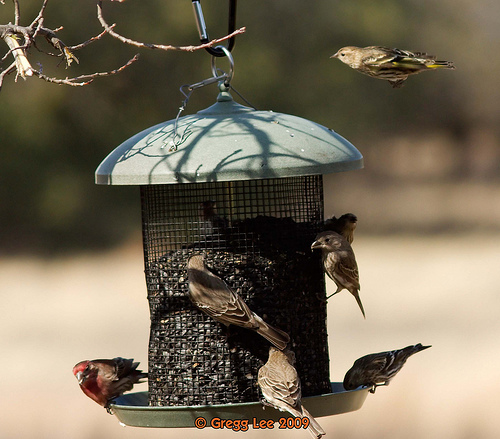

torch.Size([1, 3, 224, 224])

In [2]:
from PIL import Image

# Define the image path
image_path = '../../examples/ILSVRC2012_val_00000873.JPEG'

# Open the image
image = Image.open(image_path)

# Display the image (optional)
image.show()

# If you want to process or convert it to another format (optional)
# For example, converting to RGB
image_rgb = image.convert("RGB")
inputs = torch.tensor(processor(image_rgb)['pixel_values'])
inputs.shape

In [3]:
outputs = model(inputs, return_tuple=True)

In [11]:
print('logits', outputs.logits.shape)
print('logits_all', outputs.logits_all.shape)
print('group_attributions', outputs.group_attributions.shape)

logits torch.Size([1, 1000])
logits_all torch.Size([1, 20, 1000])
group_attributions torch.Size([1, 20, 1000])


original


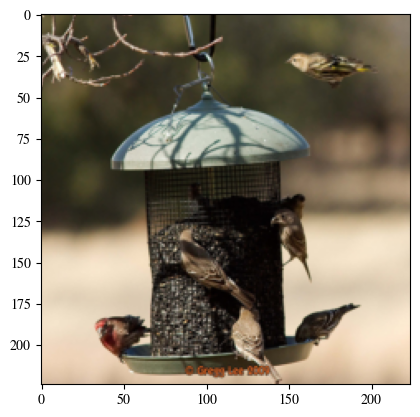

selected masks


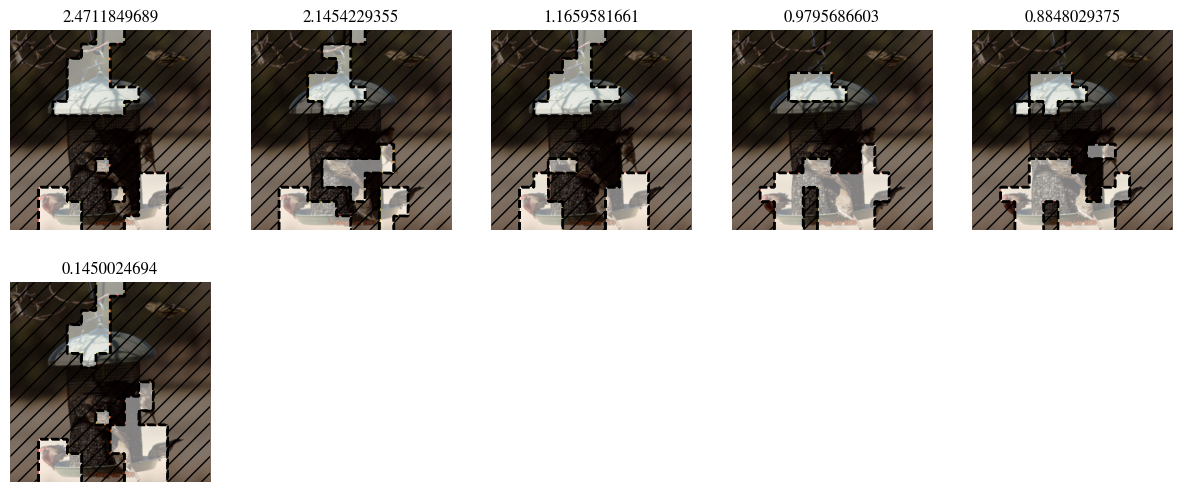

all masks


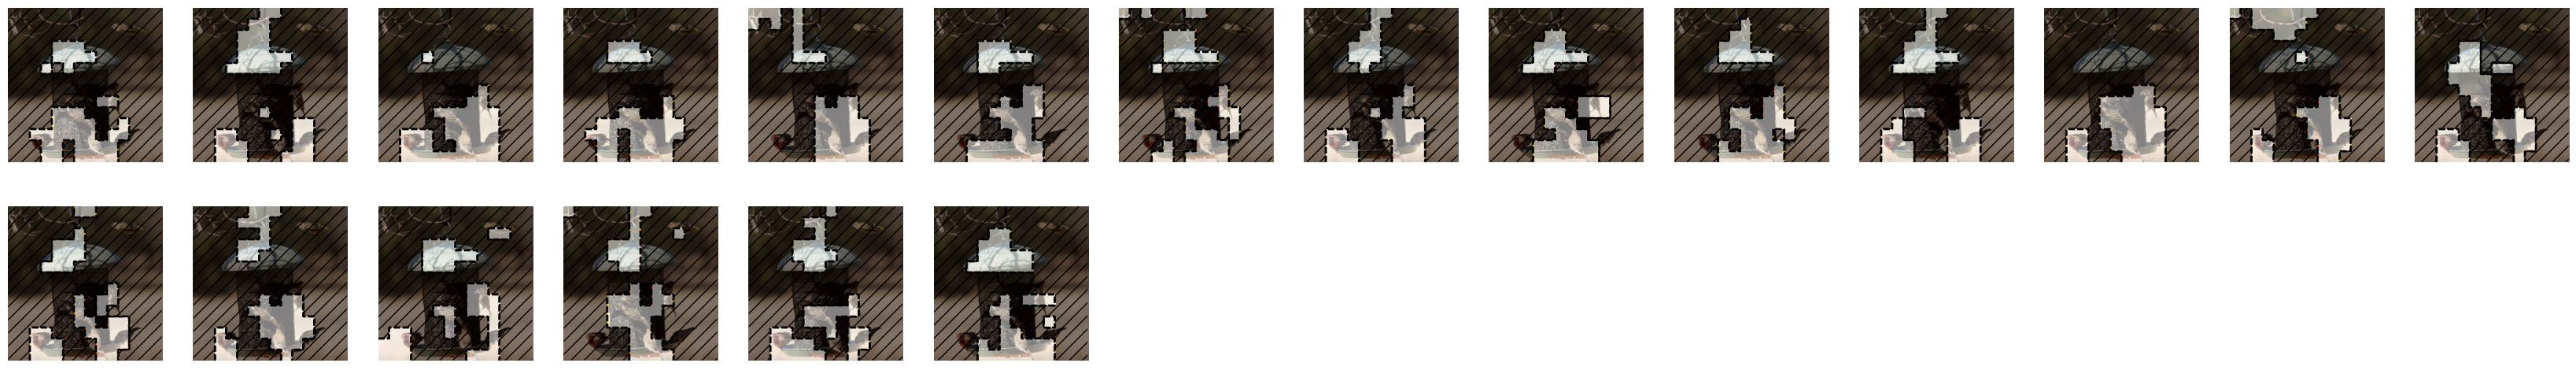

In [5]:
from exlib.modules.sop import show_masks_weights

show_masks_weights(inputs, outputs, i=0)

## Show the groups from SOP